In [16]:
import pandas as pd
import numpy as np
import math
import tools
from datetime import date
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as opt

In [17]:
plt.style.use(['dark_background'])
pd.options.display.max_rows = 20

**Import and dataframe setup**

In [18]:
df = pd.read_excel('HO-LGO.xlsm')
df = df.drop([0,1])
df = df.drop(df.columns[[4, 5, 8]],axis=1)
df.columns = ['Timestringnum','Timestamp1','BidHOc2','BidLGOc6','AskHOc2','AskLGOc6','Timestamp2','TradeVolumeHOc2','TradeVolumeLGOc6']
print('Dataframe header:')
df.head()

Dataframe header:


,Timestringnum,Timestamp1,BidHOc2,BidLGOc6,AskHOc2,AskLGOc6,Timestamp2,TradeVolumeHOc2,TradeVolumeLGOc6
2,42115.145833,2015-04-21 03:30:00,1.8717,587.25,1.8727,587.75,2015-04-21 03:30:00,370,128
3,42115.166667,2015-04-21 04:00:00,1.8829,590.75,1.8838,591,2015-04-21 04:00:00,418,284
4,42115.187500,2015-04-21 04:30:00,1.8804,589.25,1.8817,589.75,2015-04-21 04:30:00,84,338
5,42115.208333,2015-04-21 05:00:00,1.8722,587,1.874,587.5,2015-04-21 05:00:00,480,15
6,42115.229167,2015-04-21 05:30:00,1.8772,588.75,1.8784,589,2015-04-21 05:30:00,67,35


**Test/train set splitting**  
IS sample is used for calibration, and OS sample is used for testing the strategy

In [19]:
time_shift = 693594
datesIS = [date(2015,4,22),date(2016,1,21)] #IS dates
datesOS = [date(2016,1,22),date(2016,4,21)] #OS dates
[IS,OS] = tools.rightdays(df,time_shift,datesIS,datesOS)

**Trading hours selection**  
In the IS sample the 09:00-16:00 timewindow is used, when the market is the most liquid. In the OS sample all data is used, except the17:00-20:00 time window

In [20]:
hoursIS = [9,16]
ISS = tools.righthoursIS(IS,hoursIS)
hoursOS = [17,20]
OSS = tools.righthoursOS(OS,hoursOS)
print('IS size:',ISS.shape[0])
print('OS size:',OSS.shape[0]) 

IS size: 2893
OS size: 2752


**Log ratio computation**  


In [22]:
conversionHO = 42
conversionLGO = 7.44
ISS['logratio'] = tools.logratio(ISS,conversionHO,conversionLGO)
OSS['logratio'] = tools.logratio(OSS,conversionHO,conversionLGO)

**Outliers computation**  


In [23]:
[ISS_OC,OutISS] = tools.outliercheck(ISS)
[OSS_OC,OutOSS] = tools.outliercheck(OSS)
print('New IS size:',ISS_OC.shape[0])
print('IS outliers:')
display(OutISS)
print('\nNew OS size:',OSS_OC.shape[0])
print('OS outliers:')
display(OutOSS)

New IS size: 2892
IS outliers:


,Timestringnum,Timestamp1,BidHOc2,BidLGOc6,AskHOc2,AskLGOc6,Timestamp2,TradeVolumeHOc2,TradeVolumeLGOc6,logratio
2487,42188.520833,2015-07-03 12:30:00,1.81,570.75,1.954,572,2015-07-06 09:30:00,1142,1865,0.02883



New OS size: 2751
OS outliers:


,Timestringnum,Timestamp1,BidHOc2,BidLGOc6,AskHOc2,AskLGOc6,Timestamp2,TradeVolumeHOc2,TradeVolumeLGOc6,logratio
9966,42415.833333,2016-02-15 20:00:00,1.1085,344,1.1096,344.75,2016-02-17 22:00:00,10,70,0.006313


**OU fitting**  
Ornstein uhlenbeck process fitting via MLE maximisation

In [8]:
bus_days = 253
ratio_a_day = 2*(hoursIS[1] - hoursIS[0])+1
dt = 1/(bus_days*ratio_a_day)
[k, eta, sigma] = tools.MLE_estimator(ISS_OC['logratio'],dt)
print('k = ', float(k))
print('eta = ', float(eta))
print('sigma = ', float(sigma))

k =  23.274973133862293
eta =  -0.00977133242385968
sigma =  0.10154168681919348


**Transaction costs estimation**  
The model takes log-transaction-costs into account. That quantity is estimated in the `costs` function as the sample mean of the log bid-ask spread.

In [9]:
cost = tools.costs(ISS_OC)
print('cost = ', float(cost))

cost =  0.0013665526482791034


**Trading bands**  


The advantage of using an OU process lies in the existence of an analytical formula for the long-run return μ. It is therefore possible to maximize μ with respect to $ u $ and $ d $, fixed $ l $ and $ f $, thus characterizing the strategy. Furthermore, remembering that an analytical expression is available, as a function of $ u $ and $ d $, for optimal leverage it is also possible to determine the optimal levels $ u $ and $ d $ that maximize the long-run return, by only fixing the Stop-Loss. Both the μ evaluated in the optimal $ u $ and $ d $ are printed (Current function value to be taken with the inverted sign because we are minimizing -μ to obtain $ u $ and $ d $ that maximize μ) and the trading band for the different leverages considered.

In [10]:
SIGMA = sigma/np.sqrt(2*k)
theta = 1/k
leverage = [-1, 5, 2, 1] 
loss = -1.96
c = cost/SIGMA
for item in leverage:
    [band,newlev] = tools.long_run(loss,cost,theta,SIGMA,item,c)
    if item == -1:
        print('Leverage', float(newlev), ':')
        print([band[1],band[0]],'\n')
    else:
        print('Leverage', item, ':')
        print([band[1],band[0]],'\n')

Optimization terminated successfully.
         Current function value: -1.845422
         Iterations: 61
         Function evaluations: 112
Leverage 28.225480155607034 :
[-1.1064096316008594, 0.29922133992528616] 

Optimization terminated successfully.
         Current function value: -0.633249
         Iterations: 61
         Function evaluations: 117
Leverage 5 :
[-0.8517725137545357, 0.5111681911580115] 

Optimization terminated successfully.
         Current function value: -0.271422
         Iterations: 62
         Function evaluations: 115
Leverage 2 :
[-0.8628511379017498, 0.5617933591084094] 

Optimization terminated successfully.
         Current function value: -0.138856
         Iterations: 65
         Function evaluations: 118
Leverage 1 :
[-0.8693444500681994, 0.5805586875300396] 



**Statistical Bootstrap**  

The `generateOU` function takes advantage of the markovianity of an OU process to generate a * time-serie *. Generating N samples and recalibrating each of them with the `MLE_estimator` results in the * parameters * list containing N lists with their parameters. Similarly, for each simulation, the optimal trading bands are determined for the different leverages considered (* bands *).

In [ ]:
N_sample = 100 #1e4 simulazioni effettive da fare. 100 fissato per limitare il tempo di esecuzione
x0 = ISS_OC['logratio'].iloc[0]
N_steps = ISS_OC.shape[0]
parameters,bands = tools.statisticalbootstrap(k,eta,sigma,dt,N_sample,N_steps,x0,leverage,loss,cost,c)

**Confidence intervals**  


In [25]:
confidence = [2.5,97.5]
IC_k = np.percentile([lis[0] for lis in parameters] ,confidence) 
IC_eta = np.percentile([lis[1] for lis in parameters] ,confidence) 
IC_sigma = np.percentile([lis[2] for lis in parameters] ,confidence)

IC_Uopt = np.percentile([lis[0][0] for lis in bands[0]] ,confidence) 
IC_Dopt = np.percentile([lis[0][1] for lis in bands[0]] ,confidence) 
IC_levopt = np.percentile([lis[1] for lis in bands[0]] ,confidence) 

IC_U5 = np.percentile([lis[0][0] for lis in bands[1]] ,confidence) 
IC_D5 = np.percentile([lis[0][1] for lis in bands[1]] ,confidence) 

IC_U2 = np.percentile([lis[0][0] for lis in bands[2]] ,confidence) 
IC_D2 = np.percentile([lis[0][1] for lis in bands[2]] ,confidence)  

IC_U1 = np.percentile([lis[0][0] for lis in bands[3]] ,confidence) 
IC_D1 = np.percentile([lis[0][1] for lis in bands[3]] ,confidence) 

print('IC for model parameters:\n')
print('k:',IC_k)
print('eta:',IC_eta)
print('sigma:',IC_sigma)
print('\nIC with optimal leverage:\n')
print('levopt:',IC_levopt)
print('U:',IC_Uopt)
print('D:',IC_Dopt)
print('\nIC leverage 1:\n')
print('U:',IC_U1)
print('D:',IC_D1)
print('\nIC leverage 2:\n')
print('U:',IC_U2)
print('D:',IC_D2)
print('\nIC leverage 5:\n')
print('U:',IC_U5)
print('D:',IC_D5)

IC for model parameters:

k: [16.26426118 46.05296613]
eta: [-0.0184491   0.00078501]
sigma: [0.09894285 0.10366479]

IC with optimal leverage:

levopt: [23.89139186 39.25834702]
U: [0.29686882 0.30077254]
D: [-1.10800232 -1.10540031]

IC leverage 1:

U: [0.58055869 0.58055869]
D: [-0.86934445 -0.86934445]

IC leverage 2:

U: [0.55847407 0.56690456]
D: [-0.86445796 -0.86189124]

IC leverage 5:

U: [0.50013235 0.52915228]
D: [-0.85427464 -0.85117604]


**Trading strategy application**  
The `tradingStrategy` is applied on the OS dataframe, with a leverage equal to 1

In [13]:
L = loss*SIGMA
U = band[0]*SIGMA
D = band[1]*SIGMA
time_strategy = 0.2530
W0 = 1
[mu_OS,Wt,check_in,check_out] = tools.tradingStrategy(U,D,L,leverage[3],W0,time_strategy,OSS_OC,cost,eta)
print('mu = ', float(mu_OS))

mu =  0.33281024754876354


**Plot preparation**

In [14]:
#Open positions and close position
openi = [lis[0] for lis in check_in] 
openp = [lis[1] for lis in check_in] 
closei = [lis[0] for lis in check_out] 
closep = [lis[1] for lis in check_out] 
#Trading band
t = np.arange(0,OSS.shape[0],10)
Ll = np.full(len(t),loss*SIGMA+eta)
Ls = np.full(len(t),-loss*SIGMA+eta)
Dl = np.full(len(t),band[1]*SIGMA+eta)
Ds = np.full(len(t),-band[1]*SIGMA+eta)
Ul = np.full(len(t),band[0]*SIGMA+eta)
Us = np.full(len(t),-band[0]*SIGMA+eta)
OSS_OC = OSS_OC.reset_index()

**Plot**    
Plot of the trading strategy on the OS sample. Vengono messe in evidenza sia le posizioni di apertura e chiusura (long/short) che le trading bands (long/short).

<ipython-input-15-f256a3d14bf7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  lab = ax.set_xticklabels(labels)


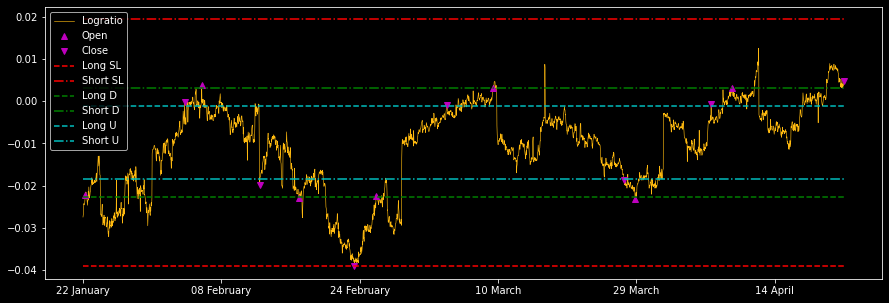

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
plt.style.use('dark_background')
plt.plot(OSS_OC['logratio'],color = (1, 0.73, 0.06), linewidth=0.6)
plt.plot(openi,openp,'m^',closei,closep,'mv',t,Ll,'r--',t,Ls,'r-.',t,Dl,'g--',t,Ds,'g-.',t,Ul,'c--',t,Us,'c-.')
plt.legend(['Logratio','Open','Close','Long SL','Short SL','Long D','Short D','Long U','Short U'])
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()][0:-1]
for i in range(len(labels)-1):
    dummie = OSS_OC['Timestamp1'][int(labels[i+1])]
    labels[i+1] = dummie.strftime("%d") +' '+ dummie.strftime("%B")
lab = ax.set_xticklabels(labels)

Application of the trading strategy over the OS data